In [10]:
high_risk_countries = ['AF', 'AO', 'AZ', 'BD', 'BY', 'BZ', 'BO', 'MM', 'KH', 'KM', 'CD', 'CI', 'CU', 'GN', 'GW', 'GY',
                       'HT', 'ID', 'IR', 'IQ', 'KZ', 'KE', 'KP', 'LA', 'LB', 'LR', 'LY', 'NG', 'PK', 'PG', 'PY', 'SL', 
                       'SX', 'SO', 'SD', 'SY', 'TH', 'TR', 'VE', 'VN', 'YE', 'ZW', 'AL', 'DZ', 'AD', 'AI', 'AR', 'AW', 
                       'BS', 'BJ', 'BM', 'BA', 'BR', 'VG', 'BN', 'BF', 'BI', 'KY', 'CF', 'TD', 'CN', 'CO', 'CK', 'CR', 
                       'CY', 'DM', 'DO', 'EC', 'EG', 'GQ', 'ER', 'GA', 'GM', 'GH', 'GI', 'GR', 'GD', 'GT', 'GG', 'HN',
                       'IM', 'JP', 'JE', 'JO', 'KR', 'KW', 'KG', 'LI', 'LU', 'MO', 'MG', 'MW', 'MY', 'MV', 'ML', 'MH', 
                       'MR', 'MX', 'MD', 'MC', 'MN', 'MS', 'MA', 'MZ', 'NP', 'NI', 'NE', 'PW', 'PA', 'PE', 'PH', 'RO', 
                       'RU', 'KN', 'LC', 'VC', 'WS', 'ST', 'SA', 'SN', 'SC', 'SB', 'SS', 'LK', 'SR', 'SZ', 'TJ', 'TZ', 
                       'TG', 'TO', 'TT', 'TN', 'TM', 'UG', 'UA', 'UY', 'UZ', 'VU', 'EH', 'ZM']

Get information on a single accountid

In [11]:
%%sql --module select_info_of_accountid
SELECT * FROM [practicum-2016:combined_test_set.cc_trans]
WHERE ACCOUNTID = 10813485

Create pie chart on the high and low risk countries

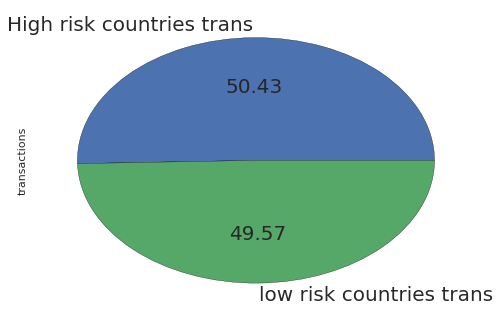

In [12]:
import gcp.bigquery as bq
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

account_info = bq.Query(select_info_of_accountid).to_dataframe()
HL_risk_country = [0,0]
for i in account_info['MERCHANT_COUNTRY']:
  if i in high_risk_countries:
    HL_risk_country[0] += 1
  else:
    HL_risk_country[1] += 1

HL_risk_country_table = pd.Series(HL_risk_country,index = ['High risk countries trans', 'low risk countries trans']
                                 ,name='transactions')
HL_risk_country_table.columns = ['numbs']
HL_risk_country_table.plot(kind ='pie', autopct='%.2f',fontsize=20)

Create query to get the high risk customers customer profiling data

In [13]:
%%sql --module select_target_table
SELECT * FROM [practicum-2016:combined_test_set.uber_cust]
WHERE ACCOUNTID IN 
(SELECT ACCOUNTID FROM [practicum-2016:combined_test_set.TOP_529])

In [15]:
%%sql --module select_rest_table
SELECT * FROM [practicum-2016:combined_test_set.uber_cust]
WHERE ACCOUNTID NOT IN 
(SELECT ACCOUNTID FROM [practicum-2016:combined_test_set.TOP_529])

Code to determine the overlap rate of the customer profilings

In [16]:
import gcp.bigquery as bq
import pandas as pd

target_table = bq.Query(select_target_table).to_dataframe()
rest_table = bq.Query(select_rest_table).to_dataframe()

YN_search = ['PEP','SAR','DEMARKET_FLAG','AUCTION','COMPLEX_HI_VEHICLE','INTERNET_GAMBLING',
            'MEDICAL_MARIJUANA_DISPENSARY','NONREGULATED_FINANCIAL_INSTITUTION',
            'THIRD_PARTY_PAYMENT_PROCESSOR','DEALER_PRECIOUS_METAL','DIGITAL_PM_OPERATOR',
            'EMBASSY_CONSULATE','EXCHANGE_CURRENCY']

TF_searching_scale = ['CASHINTENSIVE_BUSINESS','PRIVATELY_ATM_OPERATOR','HIGH_NET_WORTH','ARMS_MANUFACTURER',
                      'SALES_USED_VEHICLES','CASINO_GAMBLING']

target_table_length = target_table['ACCOUNTID'].count()
rest_table_length = rest_table['ACCOUNTID'].count()
result = {}
for i in YN_search:
  target_col = target_table[i]
  target_numb = float(target_col[target_col=='Yes'].count())/float(target_table_length)
  rest_col = rest_table[i]
  rest_numb = float(rest_col[rest_col=='Yes'].count())/float(rest_table_length)
  deno = (float(rest_col[rest_col=='Yes'].count())+float(target_col[target_col=='Yes'].count()))
  if deno == 0:
    deno=1
  result[i] = [float(target_col[target_col=='Yes'].count()),target_table_length,target_numb,
               float(target_col[target_col=='Yes'].count())/deno,
              float(rest_col[rest_col=='Yes'].count()),rest_table_length,rest_numb]

for i in TF_searching_scale:
  target_col = target_table[i]
  target_numb = float(target_col[target_col=='True'].count())/float(target_table_length)
  rest_col = rest_table[i]
  rest_numb = float(rest_col[rest_col=='True'].count())/float(rest_table_length)
  deno = (float(rest_col[rest_col=='True'].count())+float(target_col[target_col=='True'].count()))
  if deno == 0:
    deno=1
  result[i] = [float(target_col[target_col=='True'].count()),target_table_length,target_numb,
               float(target_col[target_col=='True'].count())/deno,
              float(rest_col[rest_col=='True'].count()),rest_table_length,rest_numb]

result_table = pd.DataFrame(result)
verlap_list = result_table.iloc[3][result_table.iloc[3]>0.06]
print(verlap_list)
print(result_table.iloc[3])
print(np.mean(result_table.iloc[3]))

AUCTION                          0.129032
CASHINTENSIVE_BUSINESS           0.066667
DEALER_PRECIOUS_METAL            0.105263
EMBASSY_CONSULATE                0.142857
HIGH_NET_WORTH                   0.193548
INTERNET_GAMBLING                0.086957
THIRD_PARTY_PAYMENT_PROCESSOR    0.066667
Name: 3, dtype: float64
ARMS_MANUFACTURER                     0.000000
AUCTION                               0.129032
CASHINTENSIVE_BUSINESS                0.066667
CASINO_GAMBLING                       0.048341
COMPLEX_HI_VEHICLE                    0.055556
DEALER_PRECIOUS_METAL                 0.105263
DEMARKET_FLAG                         0.000000
DIGITAL_PM_OPERATOR                   0.047619
EMBASSY_CONSULATE                     0.142857
EXCHANGE_CURRENCY                     0.000000
HIGH_NET_WORTH                        0.193548
INTERNET_GAMBLING                     0.086957
MEDICAL_MARIJUANA_DISPENSARY          0.035714
NONREGULATED_FINANCIAL_INSTITUTION    0.000000
PEP                     

In [55]:
print(result_table.columns.values)
#result_table.sort_values()
transposeResults= result_table.transpose()
sortedV = transposeResults.sort_values(by = 3)
#print(sortedV.iloc[:,3])
#print(result_table)
#print(result_table.iloc[2])
sortedV[sortedV[3] > .06][3]

['ARMS_MANUFACTURER' 'AUCTION' 'CASHINTENSIVE_BUSINESS' 'CASINO_GAMBLING'
 'COMPLEX_HI_VEHICLE' 'DEALER_PRECIOUS_METAL' 'DEMARKET_FLAG'
 'DIGITAL_PM_OPERATOR' 'EMBASSY_CONSULATE' 'EXCHANGE_CURRENCY'
 'HIGH_NET_WORTH' 'INTERNET_GAMBLING' 'MEDICAL_MARIJUANA_DISPENSARY'
 'NONREGULATED_FINANCIAL_INSTITUTION' 'PEP' 'PRIVATELY_ATM_OPERATOR'
 'SALES_USED_VEHICLES' 'SAR' 'THIRD_PARTY_PAYMENT_PROCESSOR']


CASHINTENSIVE_BUSINESS           0.066667
THIRD_PARTY_PAYMENT_PROCESSOR    0.066667
INTERNET_GAMBLING                0.086957
DEALER_PRECIOUS_METAL            0.105263
AUCTION                          0.129032
EMBASSY_CONSULATE                0.142857
HIGH_NET_WORTH                   0.193548
Name: 3, dtype: float64

In [49]:
sorted(result_table.iloc[3])
#sorted(result_table.iloc[3]).index

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.035714285714285712,
 0.047619047619047616,
 0.048341232227488151,
 0.051020408163265307,
 0.055555555555555552,
 0.066666666666666666,
 0.066666666666666666,
 0.086956521739130432,
 0.10526315789473684,
 0.12903225806451613,
 0.14285714285714285,
 0.19354838709677419]

Draw Histogram for the overlap rate

AttributeError: 'module' object has no attribute 'axhline'

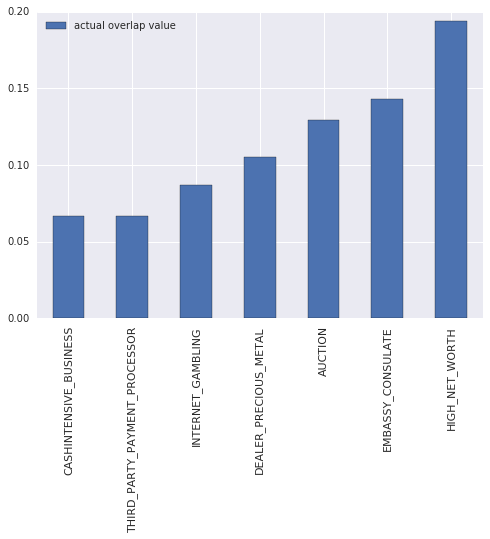

In [83]:
actual_val = pd.Series(sortedV[sortedV[3] > .06][3],name ='actual value')
actual_val_index_list = actual_val.index.tolist()
#expected_val = pd.Series([0.05,0.05,0.05,0.05,0.05,0.05,0.05],name='Expected value',index = actual_val_index_list)
show_bar_table = pd.concat([actual_val],axis=1)
show_bar_table.columns = ['actual overlap value']

show_bar_table.plot(kind ='bar', rot = 90)
plt.axhline(y=0.0529,xmin=0,xmax=1,color ='r')

Further query into the 10 main customer attributes

In [74]:
ten_cus_attributes= ['AUCTION','INTERNET_GAMBLING','MEDICAL_MARIJUANA_DISPENSARY','THIRD_PARTY_PAYMENT_PROCESSOR',
                     'DEALER_PRECIOUS_METAL','EMBASSY_CONSULATE','EXCHANGE_CURRENCY','CASHINTENSIVE_BUSINESS',
                     'HIGH_NET_WORTH','ARMS_MANUFACTURER']
count_total_att_in_529 =0
for i in ten_cus_attributes:
  count_total_att_in_529 = result_table[i].iloc[0]+count_total_att_in_529

print(count_total_att_in_529)

34.0


In [75]:
%%sql --module select_score_table
SELECT * FROM [practicum-2016:combined_test_set.Risk_score_table]

Histogrm of the Risk Score

count    9881.000000
mean        3.614715
std         2.149763
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max        14.000000
Name: RISK_SCORE, dtype: float64


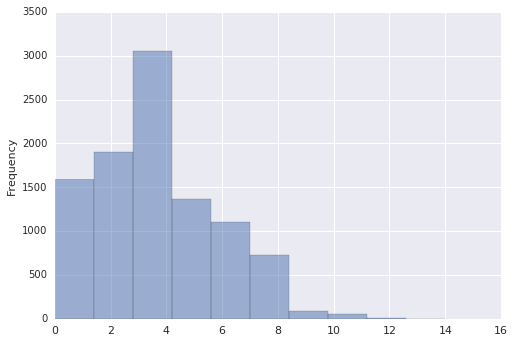

In [76]:
import gcp.bigquery as bq
import pandas as pd
import matplotlib as plt
import numpy as np

score_table = bq.Query(select_score_table).to_dataframe()
score_table['RISK_SCORE'].plot(kind='hist',alpha=0.5,stacked=True)
print(score_table['RISK_SCORE'].describe())


In [ ]:
%%bash
pip install matplotlib-venn